<a href="https://colab.research.google.com/github/jungeun919/Pytorch_study/blob/main/Dacon/Motion_keypoint_detection/keypoint_detection(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install albumentations
! pip install --upgrade albumentations

     |████████████████████████████████| 634kB 10.1MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=5b220e09080a833b80e0ad46079b694fc56aa3500b505bce56cca63b1cd2a6fd
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 952kB 10.7MB/s 
     |████████████████████████████████| 37.6MB 78kB/s 
  Found existing installation: imgaug 0.2.6
    Uninstalling imgaug-0.2.6:
      Successfully uninstalled imgaug-0.2.6
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from typing import Tuple, List, Sequence, Callable, Dict

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 상태 진행률 표시

import torch
from torch import nn, Tensor
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.ops import MultiScaleRoIAlign
from torchvision.models.detection import KeypointRCNN

import albumentations as A
from albumentations.pytorch import ToTensor

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/train_df.csv', index_col='image')
df.head()

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
image,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.000000,368.000000,1134.0,371.0,1003.497242,327.640085,1078.000000,341.00000,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.000000,335.000000,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.000000,398.000000,1144.0,337.0,1004.000000,346.000000,1094.000000,326.00000,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.187380,323.000000,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445
001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,334.109461,1020.0,381.0,1083.0,389.0,984.000000,362.000000,1163.0,372.0,1027.507419,327.383120,1111.000000,340.00000,1016.0,552.0,1061.0,556.0,1018.0,674.0,1070.0,696.0,987.703151,788.867342,1044.0,826.0,1063.029716,358.679953,1042.374777,319.031541,1101.000000,334.000000,1044.538960,442.054730,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554
001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,359.351579,968.0,392.0,1010.0,411.0,941.812612,339.703151,1109.0,441.0,971.654931,328.648429,1066.812604,383.40631,972.0,571.0,1000.0,559.0,991.0,700.0,1110.0,469.0,991.406302,816.132650,1133.0,591.0,1007.302983,374.179405,981.842327,329.109461,1057.406318,372.461040,982.937294,458.109462,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997
001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,338.187380,997.0,393.0,1054.0,395.0,961.000000,423.000000,1132.0,360.0,988.676303,357.688297,1080.000000,337.00000,1000.0,567.0,1043.0,570.0,1017.0,673.0,1059.0,701.0,998.406302,784.570501,1040.0,827.0,1036.318945,366.195727,999.777421,349.829291,1069.648429,334.109461,1024.843791,453.687572,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102


# 1. 데이터셋 전처리 및 시각화

In [6]:
def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True,
    dpi: int = 200
) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

    if boxes:
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3, colors.get(i), thickness=3, lineType=cv2.FILLED)

        if keypoint_names is not None:
            cv2.putText(
                image, 
                f'{i}: {keypoint_names[i]}', 
                tuple(keypoint), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    if edges is not None:
        for i, edge in enumerate(edges):
            cv2.line(
                image, 
                tuple(keypoints[edge[0]]), 
                tuple(keypoints[edge[1]]),
                colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    fig.savefig('example.png')

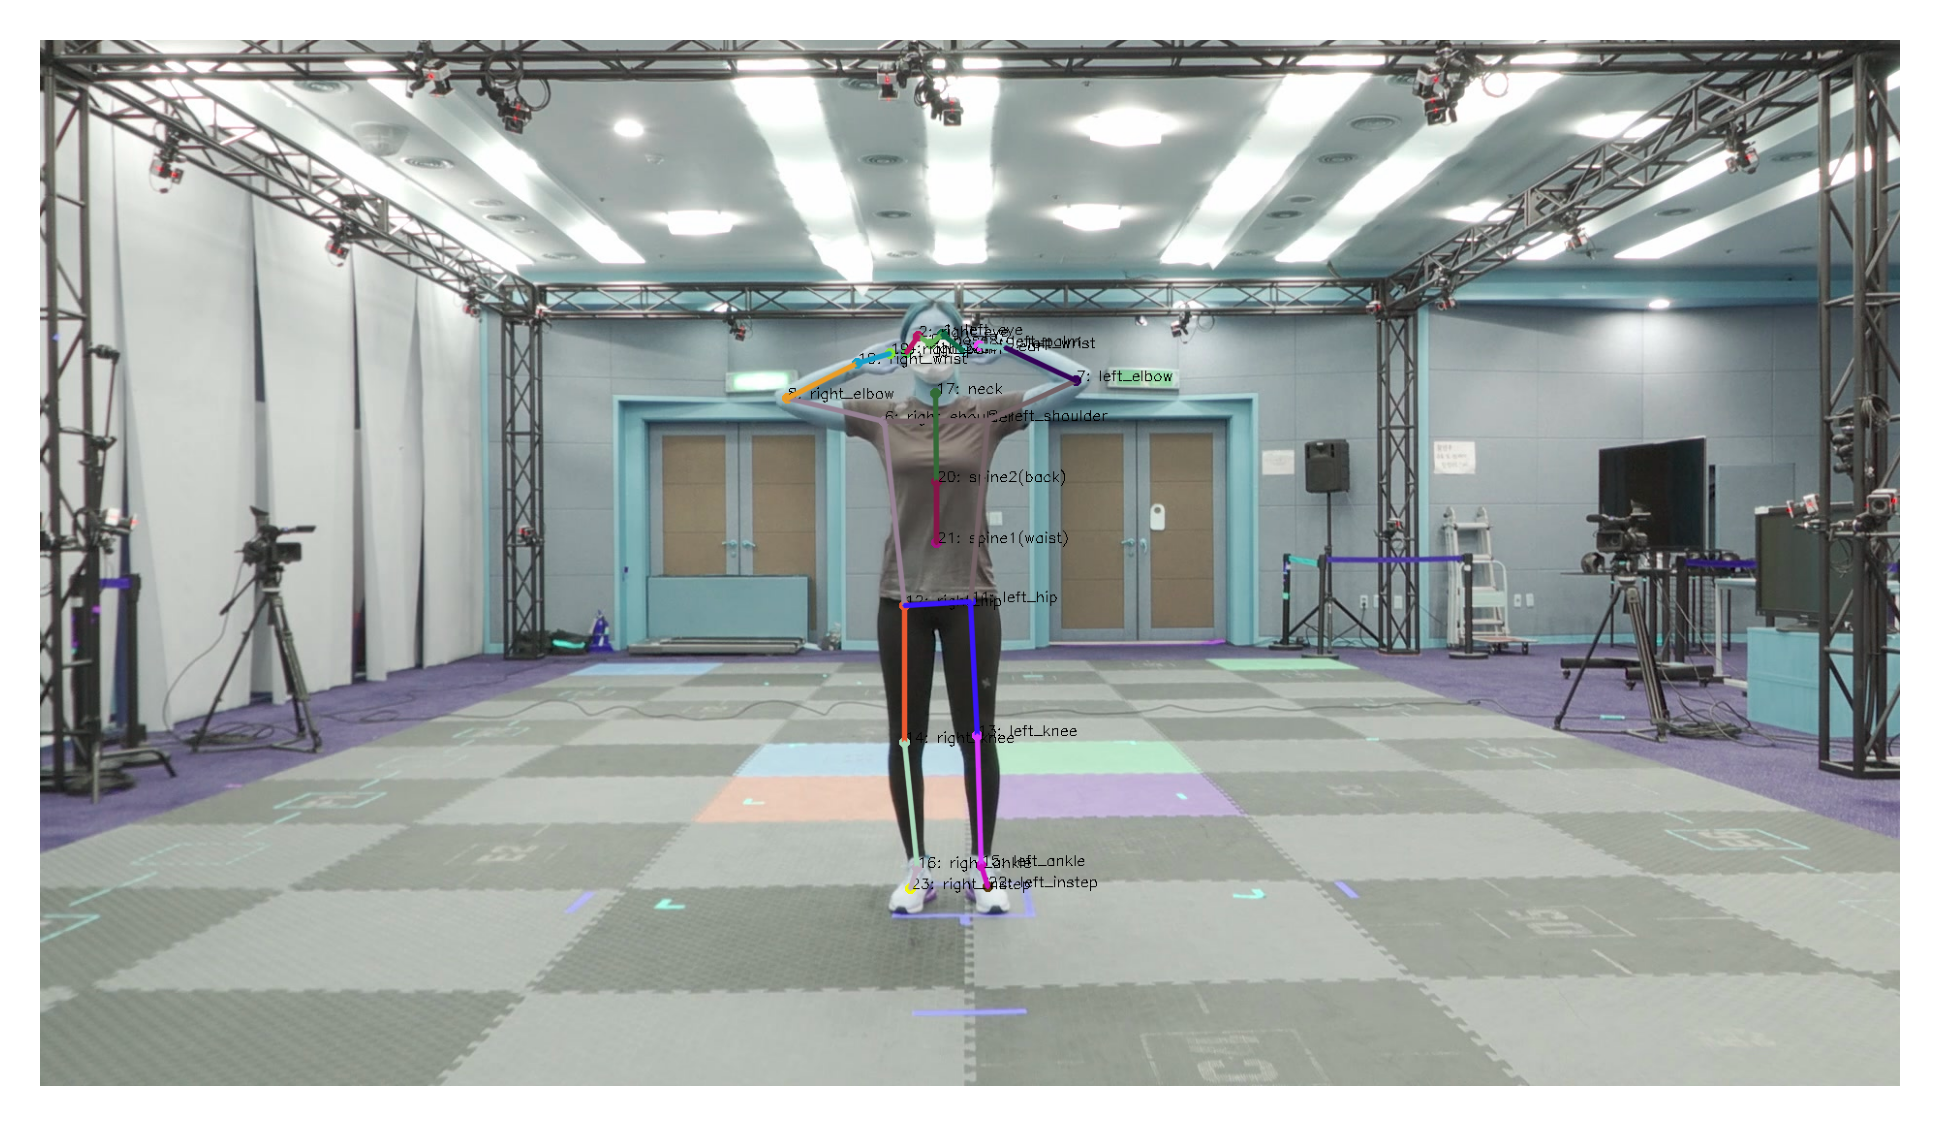

In [7]:
keypoints = df.loc['002-1-1-01-Z17_C-0000011.jpg'].values.reshape(-1, 2)
keypoints = keypoints.astype(np.int64)
keypoint_names = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder',
    7: 'left_elbow', 
    8: 'right_elbow',
    9: 'left_wrist', 
    10: 'right_wrist',
    11: 'left_hip', 
    12: 'right_hip',
    13: 'left_knee', 
    14: 'right_knee',
    15: 'left_ankle', 
    16: 'right_ankle',
    17: 'neck', 
    18: 'left_palm', 
    19: 'right_palm', 
    20: 'spine2(back)',
    21: 'spine1(waist)', 
    22: 'left_instep',
    23: 'right_instep'
}

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]

image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/train_imgs/002-1-1-01-Z17_C-0000011.jpg', cv2.COLOR_BGR2RGB)
draw_keypoints(image, keypoints, edges, keypoint_names, boxes=False, dpi=400)

# 2. torchvsion 모형을 이용한 추론

In [8]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (1333, 800))
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = keypointrcnn_resnet50_fpn(pretrained=True, progress=False)
model.eval()
preds = model(image)
preds[0].keys()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])

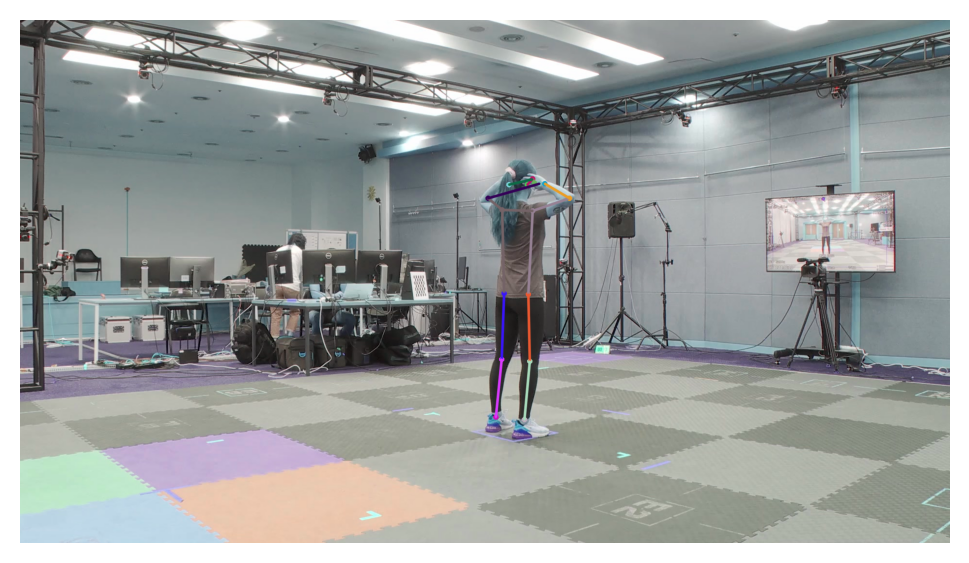

In [9]:
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)
keypoints[:, 0] *= image.shape[1]/1333
keypoints[:, 1] *= image.shape[0]/800
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10),
    (5, 7), (7, 9), (5, 11), (11, 13), (13, 15), (6, 12),
    (12, 14), (14, 16), (5, 6)
]

draw_keypoints(image, keypoints, edges, boxes=False)

# 3. keypoint R-CNN 학습하기

In [10]:
class KeypointDataset(Dataset):
    def __init__(
        self,
        image_dir: os.PathLike,
        label_path: os.PathLike,
        transforms: Sequence[Callable]=None
    ) -> None:
        self.image_dir = image_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms

    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index: int) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
            targets = self.transforms(**targets)

        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

In [11]:
transforms = A.Compose([
    ToTensor()
],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
    keypoint_params=A.KeypointParams(format='xy')
)

In [12]:
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))


trainset = KeypointDataset('/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/train_imgs', '/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/train_df.csv', transforms)
train_loader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [13]:
def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [14]:
def train(device='cuda:0'):
    model = get_model()
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
    num_epochs = 2
    for epoch in range(num_epochs):
        model.train()
        for i, (images, targets) in enumerate(train_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            losses = model(images, targets)
    
            loss = sum(loss for loss in losses.values())
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print(f'| epoch: {epoch} | loss: {loss.item():.4f}', end=' | ')
                for k, v in losses.items():
                    print(f'{k[5:]}: {v.item():.4f}', end=' | ')
                print()

In [15]:
train()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



| epoch: 0 | loss: 9.0893 | classifier: 0.2641 | box_reg: 0.0368 | keypoint: 8.0913 | objectness: 0.6765 | rpn_box_reg: 0.0205 | 
| epoch: 0 | loss: 8.8748 | classifier: 0.1475 | box_reg: 0.0150 | keypoint: 8.0922 | objectness: 0.6114 | rpn_box_reg: 0.0087 | 
| epoch: 0 | loss: 8.5612 | classifier: 0.0693 | box_reg: 0.0238 | keypoint: 7.9912 | objectness: 0.4697 | rpn_box_reg: 0.0072 | 
| epoch: 0 | loss: 8.3025 | classifier: 0.0305 | box_reg: 0.0099 | keypoint: 7.9950 | objectness: 0.2602 | rpn_box_reg: 0.0068 | 
| epoch: 0 | loss: 8.0722 | classifier: 0.0277 | box_reg: 0.0091 | keypoint: 7.8802 | objectness: 0.1367 | rpn_box_reg: 0.0184 | 
| epoch: 0 | loss: 7.9832 | classifier: 0.0427 | box_reg: 0.0182 | keypoint: 7.8172 | objectness: 0.0929 | rpn_box_reg: 0.0122 | 
| epoch: 0 | loss: 7.8091 | classifier: 0.0344 | box_reg: 0.0143 | keypoint: 7.6791 | objectness: 0.0671 | rpn_box_reg: 0.0142 | 
| epoch: 0 | loss: 7.7805 | classifier: 0.0451 | box_reg: 0.0189 | keypoint: 7.6370 | obj

# 4. 학습한 모형에서의 추론

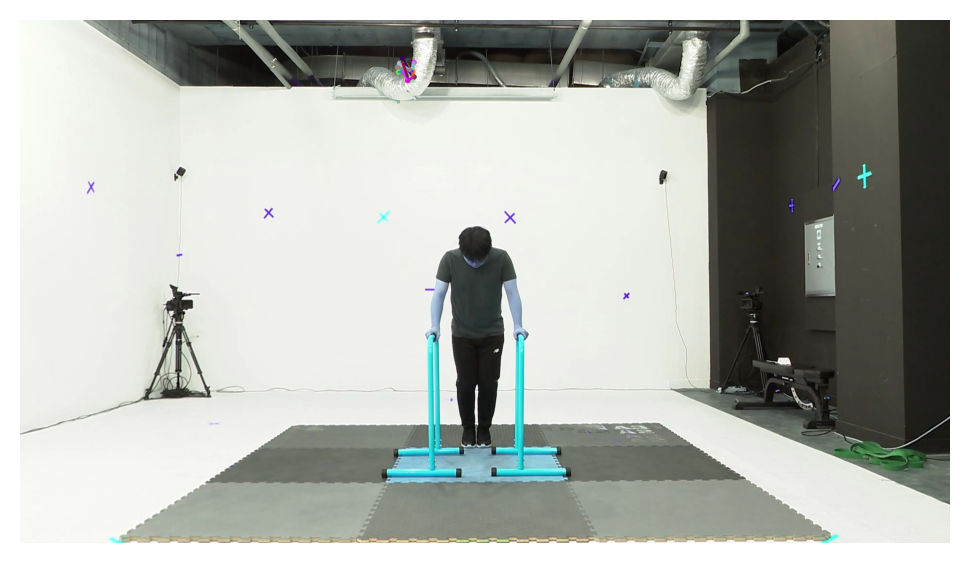

In [16]:
# from eval import get_model


image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/test_imgs/697-3-5-34-Z94_C-0000013.jpg', cv2.COLOR_BGR2RGB)
image = image / 255.0
image = image.transpose(2, 0, 1)
image = [torch.as_tensor(image, dtype=torch.float32)]

model = get_model()
# model.load_state_dict(torch.load('model-e39.pth'))
model.eval()
preds = model(image)
keypoints = preds[0]['keypoints'].detach().numpy().copy()[0]
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/dacon/keypoint_detection/1. open/1. open/test_imgs/697-3-5-34-Z94_C-0000013.jpg', cv2.COLOR_BGR2RGB)
keypoints = keypoints[:, :2]

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]

draw_keypoints(image, keypoints, edges, boxes=False)